# Comparison of velocities among RegVelo, veloVI and scVelo on cell cycle dataset

## Library imports

In [1]:
import sys

from paths import DATA_DIR

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience

import scanpy as sc
import scvelo as scv
from velovi import preprocess_data

sys.path.append("../..")

## Data loading

In [3]:
adata = sc.read("RegVelo_datasets/cell cycle/adata.h5ad")
adata.X = adata.layers["spliced"].copy()

del adata.layers["ambiguous"]
del adata.layers["matrix"]
del adata.layers["spanning"]

adata.obs.drop(
    [
        "Well_Plate",
        "plate",
        "MeanGreen530",
        "MeanRed585",
        "initial_size_unspliced",
        "initial_size_spliced",
        "initial_size",
    ],
    axis=1,
    inplace=True,
)

adata.var_names = adata.var["name"].values
adata.var.drop(adata.var.columns, axis=1, inplace=True)

adata.obs["pseudo_clusters"] = pd.cut(adata.obs["fucci_time"], bins=5, labels=False).astype(str).astype("category")

adata.obs["pseudo_clusters_equal_size"] = pd.qcut(adata.obs["fucci_time"], q=5, labels=False)
adata.obs["pseudo_clusters_equal_size_num"] = adata.obs["pseudo_clusters_equal_size"].astype(float)

adata.obs["cell_cycle_rad"] = adata.obs["fucci_time"] / adata.obs["fucci_time"].max() * 2 * np.pi

adata

/gpfs/home/jw7078/.conda/envs/regvelo/lib/python3.9/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


AnnData object with n_obs × n_vars = 1146 × 19997
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad'
    layers: 'spliced', 'unspliced'

## Data preprocessing

In [4]:
scv.pp.filter_and_normalize(adata, min_counts=10, n_top_genes=2000)

/gpfs/home/jw7078/.conda/envs/regvelo/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/home/jw7078/.conda/envs/regvelo/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/home/jw7078/.conda/envs/regvelo/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/home/jw7078/.conda/envs/regvelo/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/home/jw7078/.conda/envs/regvelo/lib/python3.9/site-packages/anndata/_core/a

Filtered out 4748 genes that are detected 10 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [5]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.pp.moments(adata)

computing neighbors


2024-10-02 15:11:35.732622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished (0:00:52) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
sc.tl.umap(adata)

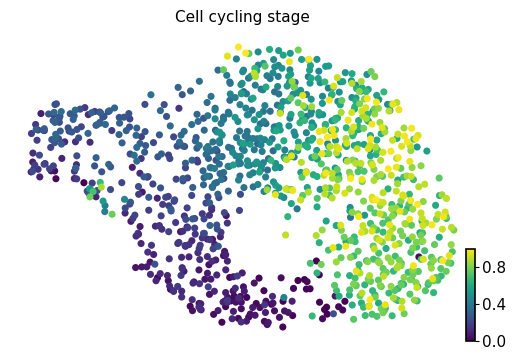

In [8]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color="fucci_time", cmap="viridis", title="Cell cycling stage", ax=ax)

/gpfs/home/jw7078/.conda/envs/regvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:861: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = palette[:length]


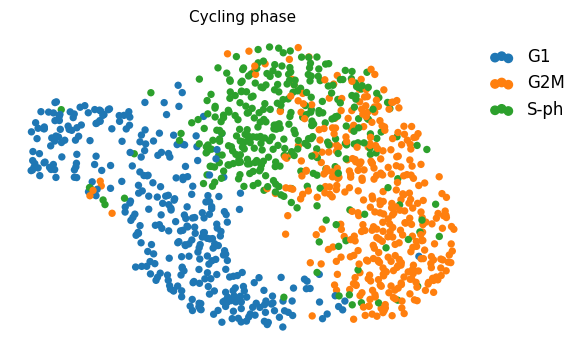

In [9]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata[adata.obs["phase"] != "N/A"], basis="umap", color="phase", title="Cycling phase", ax=ax)

In [10]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [12]:
adata.write(DATA_DIR / "cell_cycle" / "cell_cycle_processed.h5ad")

In [13]:
adata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'umap', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'